# Retagging images that were manually tagged

This code is adapted from tensorflow/tensorflow/models/image/imagenet/classify_image.py 

In [23]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools
import csv

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py

import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile
from run_inference import predict_star, predict
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Code to read in a graph + optimal parameters

In [2]:
def create_graph(pb_file):
    """"Creates a graph from saved GraphDef file and returns a Graph object.
    Returns:
    Graph holding the trained Inception network.
    """
    model_filename = pb_file
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

In [3]:
#graph = create_graph"/data/retrain_manualtags/output_graph_best.pb")
create_graph("/data/retrain_manualtags/output_graph_best.pb")
sess = tf.Session()

In [4]:
params = pickle.load(open("/data/retrain_manualtags1/output_params700.pkl", 'r'))
fw = params["final_weights"]
fb = params["final_biases"]
print fb.shape
print fw.shape

(12,)
(2048, 12)


In [5]:
labels = []
with open("/data/retrain_manualtags1/output_labels700.txt", 'r') as ifile:
    for line in ifile:
        labels.append(line.rstrip())
labels

['animals',
 'objects',
 'maps',
 'text',
 'nature',
 'people',
 'seals',
 'miniatures',
 'diagrams',
 'architecture',
 'decorations',
 'landscape']

## Code to calculate scores on an image

In [6]:
# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
    w, h = im.shape[:2]
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret


# from https://gist.github.com/yusugomori/4462221
def softmax(x):
    e = np.exp(x - np.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

In [7]:
def run_inference_on_image(image, fileType, visualize=True, verbose=True):
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.

    softmax_tensor = sess.graph.get_tensor_by_name('pool_3/_reshape:0')
    
    if fileType=='jpg':
        if not gfile.Exists(image):
            tf.logging.fatal('File does not exist %s', image)
        image_data = gfile.FastGFile(image).read()
        predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})
    elif fileType=='arr':
        image_data = [to_rgb(image)]
        predictions = sess.run(softmax_tensor, {'ExpandDims:0': image_data})
    else:
        print "Must be jpg or arr."
        return

    preds = softmax((np.dot(predictions, fw) + fb)[0])
    top_k = preds.argsort()[-12:][::-1]
    
    for node_id in top_k:
      score = preds[node_id]
      if verbose:
            print '%s (score = %.5f)' % (labels[int(node_id)], score)
       
    if visualize:
        if fileType=='jpg': plt.imshow(mpimg.imread(image), cmap=mpl.cm.gray)
        else:
            plt.imshow(image, cmap=mpl.cm.gray)

    return preds

(224, 224)
maps (score = 0.67245)
text (score = 0.09778)
diagrams (score = 0.07885)
animals (score = 0.02738)
nature (score = 0.02448)
seals (score = 0.01955)
objects (score = 0.01775)
people (score = 0.01623)
architecture (score = 0.01362)
landscape (score = 0.01197)
miniatures (score = 0.01077)
decorations (score = 0.00917)


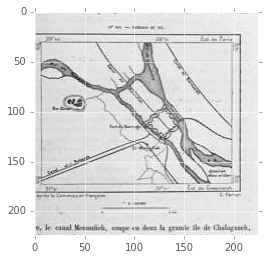

In [9]:
x = mpimg.imread("/data/reorg3/Maps/003055002_10_000599_1_.jpg")
print x.shape
preds = run_inference_on_image(x, fileType="arr")

## Read in 1K images from our hdf5 file, and score their scores in a dict

In [8]:
# read in hdf5 file
image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata.pkl", 'r'))

In [9]:
# pictures in the tagged set
tagged = set()
for folder in glob.glob("/data/reorg3/*/"):
    for fn in glob.glob(folder + ("/*.jpg")):
        tagged.add(os.path.basename(fn)[:-4])

In [10]:
image_to_idx.keys()[:5]

['002270696_0_000024_1_',
 '000744317_03_000239_2_',
 '002483175_09_000298_1_',
 '000459452_05_000382_1_',
 '003055019_02_000065_1_']

In [11]:
# run on tagged images

images_for_tagging = list(tagged)
images_for_tagging[:5]

['001102875_03_000244_1_',
 '000082783_0_000113_1_',
 '003827942_01_000305_1_',
 '000890311_02_000381_1_',
 '000550576_02_000013_1_']

In [12]:
images_to_scores = {}
args = {"images_to_scores": images_to_scores, 
        "image_to_idx": image_to_idx, 
        "image_hdf5": image_hdf5, 
        "fw": fw, 
        "fb": fb, 
        "sess": sess}
for i in range(len(images_for_tagging)):
    if i % 10 == 0: print i
    img = images_for_tagging[i]
    try:
        predict_star((img, args))
    except:
        continue


0
The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400


## Analysis of Results


### Get Ground Truth and Prediction, and get Top 3 also


In [19]:
image_to_tags_ground = {}

f = "/home/ubuntu/ArtHistoryNet/analysis/20160228_image_to_manual_tags.csv"
with open(f, 'r') as ifile:
    reader = csv.reader(ifile, delimiter='|')
    reader.next()
    for row in reader:
        short_names = '_'.join(row[1].split('_')[:4]) + '_'
        image_to_tags_ground[short_names] = row[2]

num_intop3 = 0
num_intop5 = 0
num_total = 0
image_to_tags = {}
for img in images_to_scores:
    image_to_tags[img] = labels[np.argmax(images_to_scores[img])]
    top_3_tags = np.argsort(images_to_scores[img])[::-1][:3] 
    top_3_tags = [labels[x].capitalize() for x in top_3_tags]
    top_5_tags = np.argsort(images_to_scores[img])[::-1][:5] 
    top_5_tags = [labels[x].capitalize() for x in top_5_tags]
    
    if img not in image_to_tags_ground: continue
    #print image_to_tags_ground[img], top_3_tags
    if image_to_tags_ground[img][1:] in top_3_tags:
        num_intop3 += 1
    if image_to_tags_ground[img][1:] in top_5_tags:
        num_intop5 += 1
    num_total += 1

print "Top 3 accuracy: {}".format(float(num_intop3)/num_total)
print "Top 5 accuracy: {}".format(float(num_intop5)/num_total)
#print images_to_scores.keys()[:2]
#print len(set(image_to_tags_ground.keys()) - set(images_to_scores.keys()))



Top 3 accuracy: 0.895833333333
Top 5 accuracy: 0.96056547619


### Do Analysis


In [20]:
ground_y = []
pred_y = []
x = 0
for img in image_to_tags_ground:
    if img not in image_to_tags:
        x+= 1 
        continue     
    else:
        ground_y.append(image_to_tags_ground[img][1:])
        pred_y.append(image_to_tags[img].capitalize())
    
print x
confm = confusion_matrix(ground_y, pred_y)
confm.shape

63


(12, 12)

In [31]:
import pandas as pd
data = pd.DataFrame(confm)
data.columns = sorted(labels)
data.index = sorted(labels)
data

,animals,architecture,decorations,diagrams,landscape,maps,miniatures,nature,objects,people,seals,text
animals,70,0,1,0,5,4,1,4,4,6,1,7
architecture,0,67,0,2,34,4,0,1,7,2,1,9
decorations,0,0,75,0,0,2,4,1,1,0,6,5
diagrams,0,0,0,70,0,11,0,0,7,0,1,8
landscape,1,9,0,0,51,2,0,23,3,1,1,12
maps,1,0,0,5,0,88,0,1,1,0,0,3
miniatures,0,0,5,1,0,4,65,0,0,0,13,2
nature,1,0,10,0,20,3,0,49,4,2,0,8
objects,1,3,1,10,4,7,0,1,64,3,5,3
people,13,3,0,1,11,9,1,20,16,139,8,9


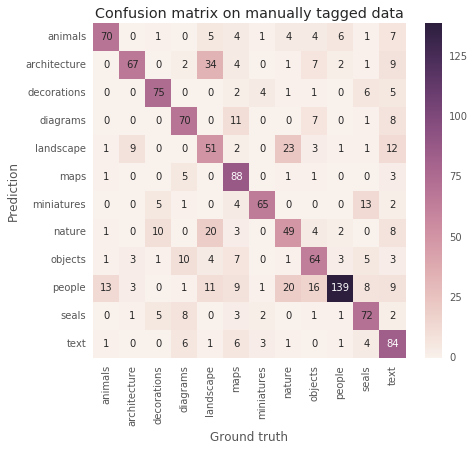

In [41]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
sns.heatmap(data, annot=True, fmt='d')
ax.set_xlabel("Ground truth")
ax.set_ylabel("Prediction")
plt.title("Confusion matrix on manually tagged data")
plt.savefig("confusion_matrix_manualtag.pdf", format='pdf')